Removing 41223 outlier rows.
Removing 41223 outlier rows.


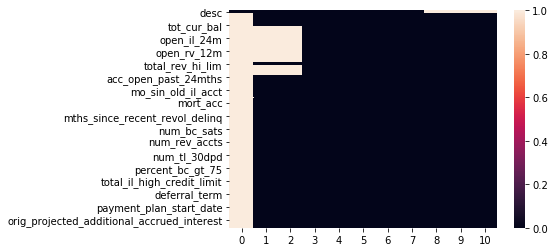

In [4]:
from lendingclub.modeling_data import ModelingData
from lendingclub.lendingclub import LendingClub
from lendingclub.config import Config
from lendingclub.scorer import Scorer
from lendingclub.model import Model
from copy import copy
import pandas as pd
import numpy as np

lc = LendingClub(Config('config.ini'))

lc.build_historic_data(data_split_type='stratified', historic_data_dir='historical_data/')

train_md_roi = ModelingData(data=lc.train_data, target='roi')
train_md_roi.build()
train_md_roi.remove_outliers()

train_md_co = ModelingData(data=lc.train_data, target='charge_off')
train_md_co.build()
train_md_co.remove_outliers()

In [8]:
charge_off_model = Model(train_md_co)
# charge_off_model.tune_hyperparams(n_calls=20)
charge_off_model.best_params = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.64846976866569173,
 'gamma': 1.9219085364634996,
 'learning_rate': 0.086252656490571317,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 32,
 'missing': None,
 'n_estimators': 114,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 3,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
charge_off_model.fit()
charge_off_model.save(model_name='charge_off_model')

In [9]:
roi_model = Model(train_md_roi)
# roi_model.tune_hyperparams(n_calls=20)
roi_model.fit()
roi_model.save(model_name='roi_model')

In [10]:
validation_md_roi = ModelingData(lc.validation_data, target='roi')
validation_md_roi.build()

validation_md_co = ModelingData(lc.validation_data, target='charge_off')
validation_md_co.build()

In [11]:
roi_scorer = Scorer(model='saved_models/roi_model.pkl', data=validation_md_roi)
roi_scorer.score()

charge_off_scorer = Scorer(model='saved_models/charge_off_model.pkl', data=validation_md_co)
charge_off_scorer.score()

Dropping id
Dropping id


In [12]:
test = copy(charge_off_scorer.data.modeling_data)
test['roi_actual'] = roi_scorer.data.target
test['roi_pred'] = roi_scorer.preds
test['charge_off_actual'] = charge_off_scorer.data.target
test['charge_off_pred'] = charge_off_scorer.preds

In [13]:
import pandas as pd
import numpy as np
buy = test.loc[(test.roi_pred > 0.19) & (test.charge_off_pred < 0.02)]
buy = pd.merge(lc.master_df[['id', 'total_pymnt']], buy, on='id')

In [14]:
print('Model Selection Net Return: ' + str(np.sum(buy.total_pymnt) - np.sum(buy.funded_amnt)))
print('Model Selection ROI: ' + str((np.sum(buy.total_pymnt) - np.sum(buy.funded_amnt)) / np.sum(buy.funded_amnt) * 100))

print('Number of notes invested:', str(len(buy.index)))
print('Percent of notes invested:', str(len(buy.index) / len(test.index) * 100))

Model Selection Net Return: 5083714.53809
Model Selection ROI: 12.3045735408
Number of notes invested: 1884
Percent of notes invested: 1.0658339132058179
